In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load the dataset
csv_file_path = "/content/investigator_nacc63.csv"
df = pd.read_csv(csv_file_path)

<ipython-input-2-d9d4e9a60af2>:3: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,397,399,401,423,432,445,454,494,574,605,613,638,674,690,707,710,727,744,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


#**Data Explorations**

In [ ]:
# Display the first few rows of the dataset
df.head()

,NACCID,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
0,NACC002909,186,I,3.0,12,28,2022,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
1,NACC004352,186,I,3.0,10,5,2021,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
2,NACC004687,186,I,3.0,11,14,2022,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
3,NACC008514,186,I,3.0,11,15,2022,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0
4,NACC013667,186,I,3.0,3,29,2022,1,1,1,...,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0


In [ ]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20953 entries, 0 to 20952
Columns: 1024 entries, NACCID to NPATGFR4
dtypes: float64(445), int64(437), object(142)
memory usage: 163.7+ MB


In [ ]:
# Display summary statistics
df.describe()

,NACCADC,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,NACCDAYS,NACCFDYS,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
count,20953.000000,20953.000000,20953.000000,20953.000000,20953.000000,20953.000000,20953.000000,20953.000000,20953.000000,20953.000000,...,20952.000000,20952.000000,20952.000000,20952.000000,20952.000000,20952.000000,20952.000000,20952.000000,20952.000000,20952.000000
mean,440.003627,2.456307,6.316136,15.435785,2014.941918,3.009832,5.020236,4.284780,1834.176347,899.571804,...,-3.954229,-3.953322,-3.952176,-3.953799,-3.954038,-3.888173,-3.969406,-3.968404,-3.969502,-3.969072
std,221.341223,0.667649,3.413134,8.558783,5.027987,2.515928,3.597318,3.214236,1610.470531,1127.881181,...,0.679627,0.691160,0.698980,0.687662,0.686045,1.109812,0.577421,0.585943,0.576682,0.580002
min,186.000000,1.000000,1.000000,1.000000,2005.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
25%,289.000000,2.000000,3.000000,8.000000,2011.000000,1.000000,2.000000,2.000000,448.000000,0.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
50%,354.000000,3.000000,6.000000,15.000000,2015.000000,2.000000,4.000000,3.000000,1483.000000,443.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
75%,490.000000,3.000000,9.000000,22.000000,2019.000000,4.000000,7.000000,6.000000,2769.000000,1366.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
max,943.000000,3.200000,12.000000,31.000000,2023.000000,18.000000,18.000000,17.000000,6392.000000,6392.000000,...,8.000000,8.000000,8.000000,8.000000,8.000000,9.000000,8.000000,8.000000,8.000000,8.000000


In [ ]:
# Sum of missing values for each column
missing_values = df.isnull().sum()
missing_values

,0
NACCID,0
NACCADC,0
PACKET,0
FORMVER,0
VISITMO,0
...,...
NPATGFRN,1
NPATGFR1,1
NPATGFR2,1
NPATGFR3,1


In [ ]:
# Total number of missing values
missing_values.nunique()

122

In [ ]:
df['NACCID'].value_counts()

,count
NACCID,
NACC263960,18
NACC283729,17
NACC429035,17
NACC056647,16
NACC932623,16
...,...
NACC089439,1
NACC100509,1
NACC113458,1


In [ ]:
#Unique number of subjects
df['NACCID'].nunique()

7638

In [ ]:
df['NACCID'].isnull().sum()

0

In [ ]:
df['NACCVNUM'].nunique()

18

In [ ]:
# Missing value in NACCVNUM column
df['NACCVNUM'].isnull().sum()

0

In [ ]:
# Assuming 'BIRTHYR' is the column you want to extract values from
birthyr_column = 'BIRTHYR'

In [ ]:
# Display the first 10 values of the 'BIRTHYR' column
first_10_values = df[birthyr_column].head(10)
print(f'First 10 values of {birthyr_column} column:\n{first_10_values}')

First 10 values of BIRTHYR column:
0    1952
1    1958
2    1945
3    1936
4    1945
5    1952
6    1947
7    1938
8    1952
9    1958
Name: BIRTHYR, dtype: int64


#**Data Preprocessing for LSTM Model**

In [ ]:
# Function for preprocessing
def preprocess_data(df):
    # Define the columns to keep
    feature_cols = ['SEX', 'BIRTHYR', 'NACCMMSE', 'CDRGLOB', 'NACCALZP', 'BOSTON', 'TRAILA', 'TRAILB',
                    'CSFTAU', 'TAUPETAD', 'AMYLCSF', 'AMYLPET', 'DIABET', 'AFIBRILL', 'HYPERT', 'HYPCHOL',
                    'VB12DEF', 'THYDIS', 'ANGIOPCI', 'NACCALZD', 'PENTAGON', 'BRNINJ', 'DEP', 'EPILEP',
                    'SCHIZOP', 'PTSDDX', 'OTHPSY', 'ALCDEM', 'IMPSUB', 'MEDS']

    # Create 'AGE' column, convert 'BIRTHYR' to 'AGE'
    current_year = pd.to_datetime('today').year
    df['AGE'] = current_year - df['BIRTHYR']
    df = df.drop(columns=['BIRTHYR'])  # Drop the 'BIRTHYR' column

    # Update feature_cols to reflect the new 'AGE' column
    feature_cols[feature_cols.index('BIRTHYR')] = 'AGE'

    # Identify and encode categorical columns (excluding 'NACCUDSD')
    object_columns = df.select_dtypes(include='object').columns
    for col in object_columns:
        if col != 'NACCUDSD':  # Exclude the target variable from label encoding
            df[col] = pd.factorize(df[col])[0]

    # Handle 'inf' and 'NaN' values in numerical columns
    numerical_columns = df[feature_cols].select_dtypes(include=['float64', 'int64']).columns
    df[numerical_columns] = df[numerical_columns].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Normalize features: Apply MinMaxScaler only to numerical columns
    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    # Mapping for the target variable (class labels)
    class_mapping = {1: 0, 2: 1, 3: 2, 4: 3}
    df['NACCUDSD'] = df['NACCUDSD'].map(class_mapping)

    # Define target features
    target = df['NACCUDSD']

    # Include 'NACCVNUM' for time step in the feature columns
    feature_cols.append('NACCVNUM')

    # Filter the dataframe to keep only selected feature columns, target column, and NACCVNUM
    df = df[feature_cols + ['NACCUDSD']]

    return df, feature_cols, target


In [ ]:
# Perform preprocessing
df, feature_cols, target = preprocess_data(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20953 entries, 0 to 20952
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEX       20953 non-null  float64
 1   AGE       20953 non-null  float64
 2   NACCMMSE  20953 non-null  float64
 3   CDRGLOB   20953 non-null  float64
 4   NACCALZP  20953 non-null  float64
 5   BOSTON    20953 non-null  float64
 6   TRAILA    20953 non-null  float64
 7   TRAILB    20953 non-null  float64
 8   CSFTAU    20953 non-null  float64
 9   TAUPETAD  20953 non-null  float64
 10  AMYLCSF   20953 non-null  float64
 11  AMYLPET   20953 non-null  float64
 12  DIABET    20953 non-null  float64
 13  AFIBRILL  20953 non-null  float64
 14  HYPERT    20953 non-null  float64
 15  HYPCHOL   20953 non-null  float64
 16  VB12DEF   20953 non-null  float64
 17  THYDIS    20953 non-null  float64
 18  ANGIOPCI  20953 non-null  float64
 19  NACCALZD  20953 non-null  float64
 20  PENTAGON  20953 non-null  fl

In [ ]:
df.isnull().sum()

1

In [ ]:
# Display the first few rows of the preprocessed dataset
df.head()

,SEX,AGE,NACCMMSE,CDRGLOB,NACCALZP,BOSTON,TRAILA,TRAILB,CSFTAU,TAUPETAD,...,DEP,EPILEP,SCHIZOP,PTSDDX,OTHPSY,ALCDEM,IMPSUB,MEDS,NACCVNUM,NACCUDSD
0,0.0,0.476636,0.0,0.005051,0.125,0.0,0.054890,0.090818,1.0,1.0,...,0.0,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,2.0
1,1.0,0.420561,0.0,0.010101,0.125,0.0,0.153693,0.998004,1.0,1.0,...,0.0,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3.0
2,0.0,0.542056,0.0,0.000000,1.000,0.0,0.066866,0.111776,1.0,1.0,...,0.0,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,0.0
3,0.0,0.626168,0.0,0.005051,0.250,0.0,0.074850,0.303393,1.0,1.0,...,0.0,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3.0
4,0.0,0.542056,0.0,0.010101,0.125,0.0,0.063872,0.303393,1.0,1.0,...,0.0,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3.0


# **VISIUALISATION FUNCTIONS SECTION BEGINS**

In [ ]:
# function for tree map plotting
import plotly.express as px

def generate_treemap(df, column, labels=None, value_range=None):
    # Filter the DataFrame based on the specified value range
    if value_range is not None:
        df = df[df[column].between(*value_range)]

    # Get unique categories/values from the specified column
    categories = df[column].unique()

    # Create a DataFrame for counting occurrences of each category
    count_df = pd.DataFrame(index=categories, columns=['Count'])

    # Fill the DataFrame with counts
    for category in categories:
        count_df.loc[category, 'Count'] = (df[column] == category).sum()

    # Reset the index for plotting
    count_df = count_df.reset_index()

    # Rename columns for better plot labels
    count_df.columns = ['Category', 'Count']

    # Create a treemap using plotly
    title = f'Distribution of {column} Categories'
    if value_range is not None:
        title += f' (Values between {value_range[0]} and {value_range[1]})'

    fig = px.treemap(count_df, path=['Category'], values='Count', title=title)

    # Show the interactive treemap
    fig.show()

In [ ]:
# function for scatter and 2D density plot
import matplotlib.pyplot as plt
import seaborn as sns

def plot_column_vs_column(df, x_column, y_column, plot_type='scatter', values_range=None, **kwargs):
    """
    Plot a column against another column and display correlation value.

    Parameters:
    - df: DataFrame
    - x_column: str, column name for the x-axis
    - y_column: str, column name for the y-axis
    - plot_type: str, 'scatter' or 'density', default is 'scatter'
    - values_range: tuple or list, range of values to include in the plot (optional)
    - **kwargs: additional keyword arguments for customization

    Returns:
    - None
    """
    plt.figure(figsize=(12, 6))

    if values_range:
        df_filtered = df[df[x_column].isin(values_range)]
    else:
        df_filtered = df

    if plot_type == 'scatter':
        sns.scatterplot(x=df_filtered[x_column], y=df_filtered[y_column], **kwargs)
        plt.title(f'Scatter Plot of {x_column} vs {y_column}')
    elif plot_type == 'density':
        sns.kdeplot(x=df_filtered[x_column], y=df_filtered[y_column], fill=True, cmap='viridis', levels=20, **kwargs)
        plt.title(f'2D Density Plot of {x_column} vs {y_column}')

    plt.xlabel(x_column)
    plt.ylabel(y_column)

    # Calculate and display correlation value
    correlation_coefficient = df_filtered[x_column].corr(df_filtered[y_column])
    plt.text(0.5, 0.95, f'Correlation: {correlation_coefficient:.2f}', horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

    plt.show()

In [ ]:
# Function for bar cahrt
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(df, column, title=None, xlabel=None, ylabel=None, hue=None, palette=None, custom_labels=None, show_legend=True):
    """
    Plot a bar chart for a specified column in the DataFrame.

    Parameters:
    - df: DataFrame
    - column: str, column name for the bar chart
    - title: str, title of the plot (optional)
    - xlabel: str, label for the x-axis (optional)
    - ylabel: str, label for the y-axis (optional)
    - hue: str, column name for grouping (optional)
    - palette: list, custom color palette for bars (optional)
    - custom_labels: dict, custom labels for specific values in the column (optional)
    - show_legend: bool, whether to show the legend (default is True)

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    if palette is None:
        palette = 'Set2'  # Default seaborn color palette

    sns.countplot(x=column, data=df, hue=hue, palette=palette)

    plt.title(title if title else f'Bar Chart for {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel if ylabel else 'Count')

    if custom_labels:
        # Explicitly set the x-axis ticks at the center of each bar
        unique_values = df[column].unique()
        x_ticks_positions = range(len(unique_values))
        plt.xticks(x_ticks_positions, labels=[custom_labels.get(value, value) for value in unique_values])

    if show_legend and hue:
        # Modify legend labels to show both original values and custom labels
        legend_labels = [f"{value} ({custom_labels.get(value, value)})" for value in df[hue].unique()]
        plt.legend(title=hue, labels=legend_labels)

    plt.show()

In [ ]:
# Histogram plot function
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram(df, column, title=None, xlabel=None, ylabel=None, color='blue', value_range=None, bins=20):
    """
    Plot a histogram for a specified column in a DataFrame.

    Parameters:
    - df: DataFrame
    - column: str, column name
    - title: str, plot title (optional)
    - xlabel: str, x-axis label (optional)
    - ylabel: str, y-axis label (optional)
    - color: str, color of the histogram bars (default is 'blue')
    - bins: int or sequence, number of bins or bin edges (default is 20)

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    # Plot histogram using Seaborn
    sns.histplot(df[column], color=color, bins=bins)

    # Set plot title and labels
    plt.title(title if title else f'Histogram of {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel if ylabel else 'Frequency')

    # Show the plot
    plt.show()

In [ ]:
# two column barchart comparison

import seaborn as sns
import matplotlib.pyplot as plt

def plot_count_distribution(df, column1, column2, value_range=None, palette='Set2', legend_labels=None):
    """
    Plot the count distribution of two columns in the DataFrame.

    Parameters:
    - df: DataFrame
    - column1: str, column name for the x-axis
    - column2: str, column name for the hue (grouping)
    - value_range: tuple or list, range of values to include in the plot (optional)
    - palette: str or list, color palette for the plot (optional)
    - legend_labels: dict, custom labels for the legend (optional)

    Returns:
    - None
    """
    # Filter the DataFrame based on the specified value range
    if value_range is not None:
        df_filtered = df[df[column1].between(*value_range)]
    else:
        df_filtered = df

    # Map numerical values to labels
    df_filtered[column2] = df_filtered[column2].map(legend_labels)

    # Count the occurrences of each combination of column1 and column2
    count_df = df_filtered.groupby([column2, column1]).size().reset_index(name='Count')

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=column1, y='Count', hue=column2, data=count_df, palette=palette)

    # Set plot title and labels
    plt.title(f'Number of {column2}s Across {column1} Scores')
    plt.xlabel(column1)
    plt.ylabel('Count')

    # Customize legend labels
    if legend_labels:
        plt.legend(title=column2, labels=legend_labels)

    # Show the plot
    plt.show()

# **Class balancing of target variables**

In [ ]:
# Print class distribution
print("Class distribution:")
print(df['NACCUDSD'].value_counts())

Class distribution:
NACCUDSD
0    87792
3    55306
2    31914
1     8085
Name: count, dtype: int64


<ipython-input-20-0213af92607c>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, hue=hue, palette=palette)


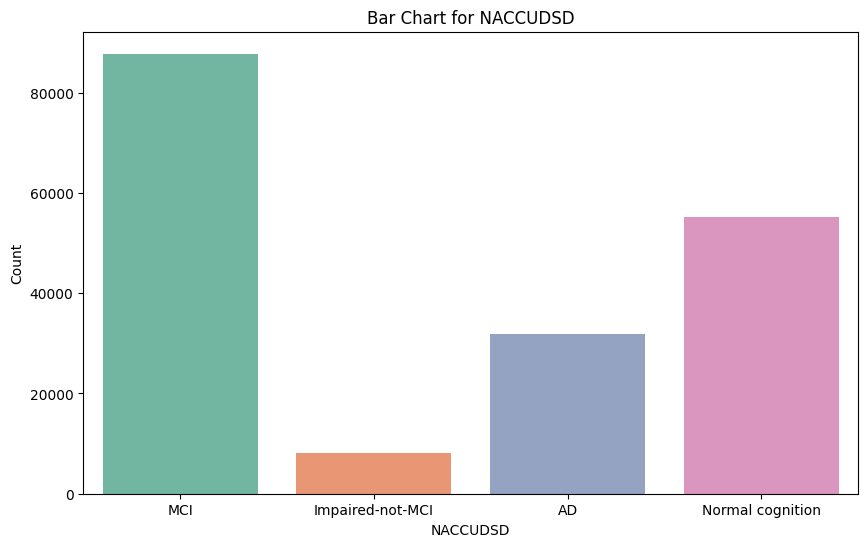

In [ ]:
# visaulising target variable before class balancing
desired_column = 'NACCUDSD'
custom_labels = {0: 'Normal cognition', 1: 'Impaired-not-MCI', 2: 'MCI', 3: 'AD'}  # Labels
plot_bar_chart(df, desired_column, custom_labels=custom_labels, show_legend=True)

In [ ]:
# Class balancing
# Assuming you have a DataFrame named 'df' and the target variable is 'NACCUDSD'
# Separate the majority and minority classes
majority_class = df[df['NACCUDSD'] == 0]  # Assuming '2' is the majority class
minority_class_2 = df[df['NACCUDSD'] == 3]
minority_class_1 = df[df['NACCUDSD'] == 2]
minority_class_0 = df[df['NACCUDSD'] == 1]
# Oversample the minority classes to match the size of the majority class
minority_oversampled_2 = minority_class_2.sample(len(majority_class), replace=True, random_state=42)
minority_oversampled_1 = minority_class_1.sample(len(majority_class), replace=True, random_state=42)
minority_oversampled_0 = minority_class_0.sample(len(majority_class), replace=True, random_state=42)

# Concatenate the majority class with the oversampled minority classes
balanced_df = pd.concat([majority_class, minority_oversampled_2, minority_oversampled_1, minority_oversampled_0])

# Shuffle the DataFrame to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Update the target column name if needed
df = balanced_df

In [ ]:
# Print class distribution
print("Class distribution:")
print(df['NACCUDSD'].value_counts())

Class distribution:
NACCUDSD
2    87792
0    87792
3    87792
1    87792
Name: count, dtype: int64


<ipython-input-20-0213af92607c>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, hue=hue, palette=palette)


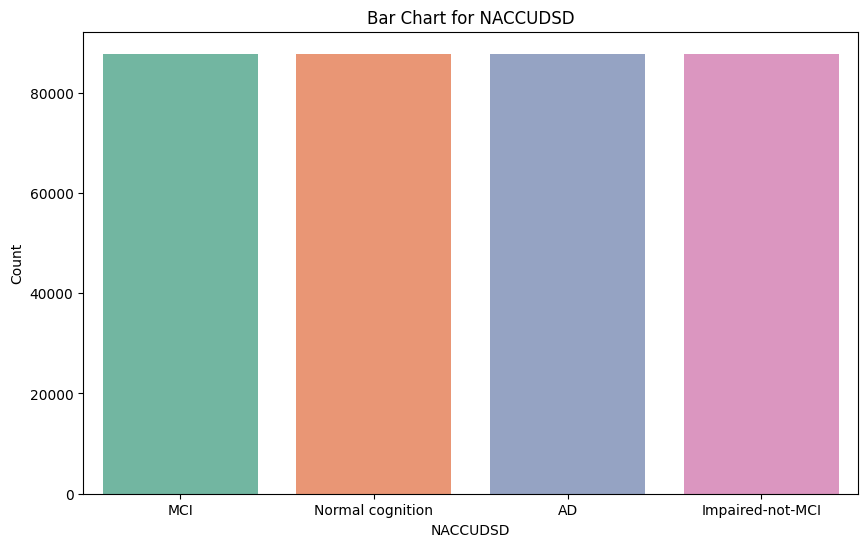

In [ ]:
# Viualising target variable after class balancing
desired_column = 'NACCUDSD'
custom_labels = {0: 'Normal cognition', 1: 'Impaired-not-MCI', 2: 'MCI', 3: 'AD'}  # Labels
plot_bar_chart(df, desired_column, custom_labels=custom_labels, show_legend=True)

# **VISUALISATION CALLS**

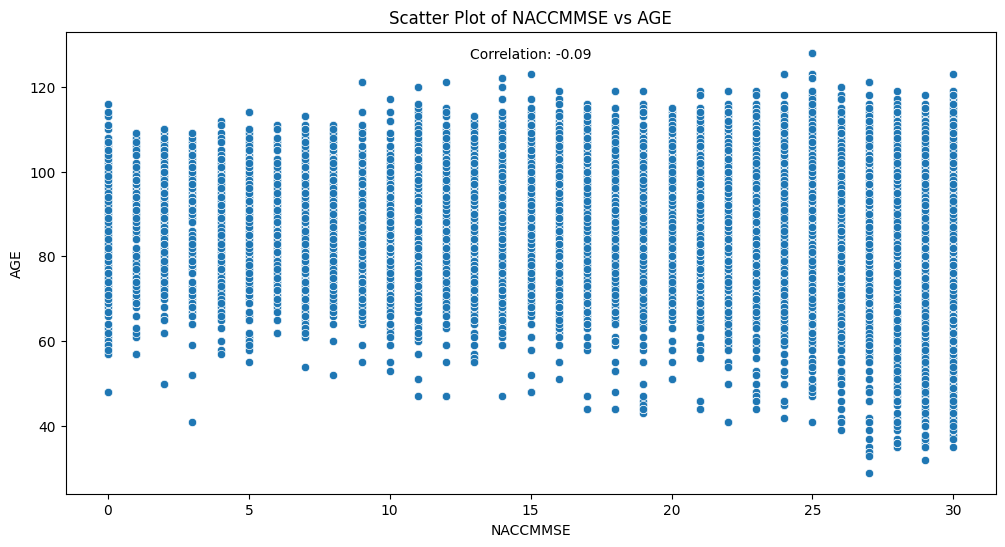

In [ ]:
# scatter plot for Age against MMSE score
plot_column_vs_column(df, 'NACCMMSE', 'AGE', plot_type='scatter', values_range=(range(31)))

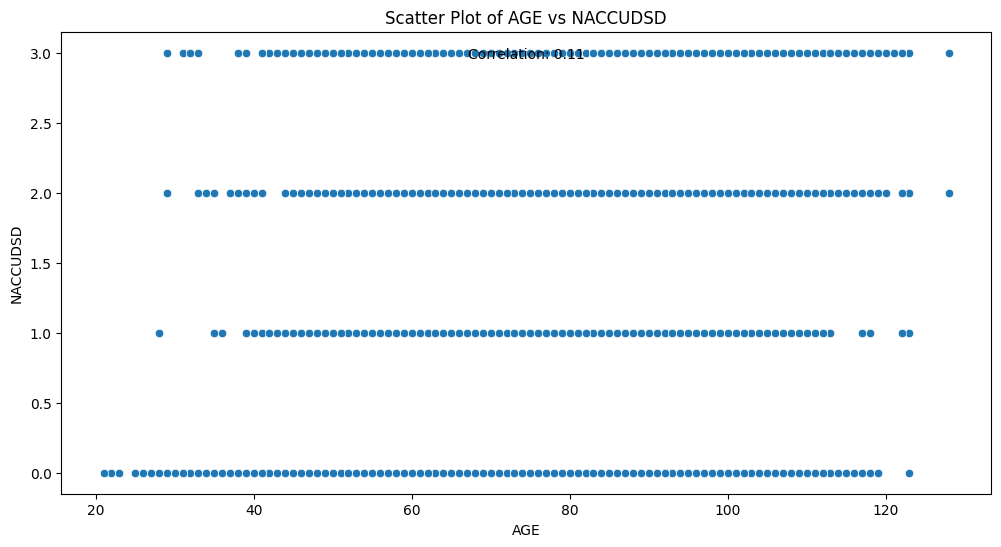

In [ ]:
# correlation scatter plot for AGE against target variable NACCUDSD
plot_column_vs_column(df, 'AGE', 'NACCUDSD', plot_type='scatter')

In [ ]:
# Treemap plot for Age distribution
generate_treemap(df, 'AGE')

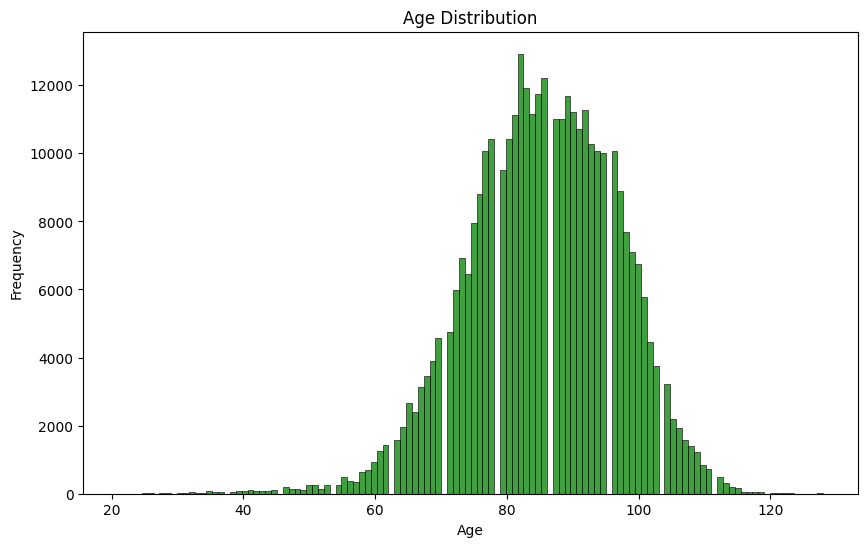

In [ ]:
# Histogram Plot for Age distribution
plot_histogram(df, 'AGE', title='Age Distribution', xlabel='Age', ylabel='Frequency', color='green', bins=120)

In [ ]:
# Distribution of all value in Total MMSE score 'NACCMMSE' column
generate_treemap(df, 'NACCMMSE')

In [ ]:
# Distribution of total MMSE score 'NACCMMSE' value 0 to 30 only
generate_treemap(df, 'NACCMMSE', value_range = (0,30))

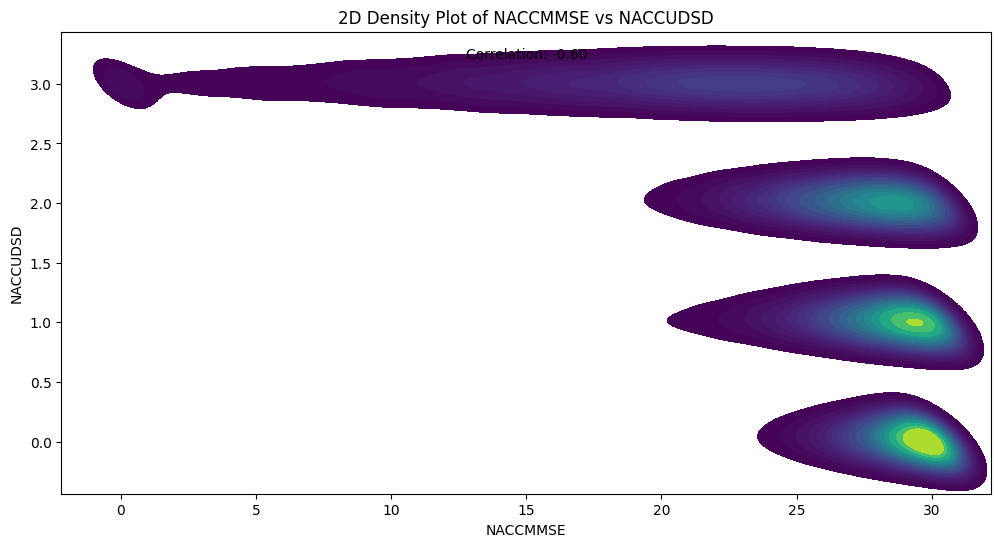

In [ ]:
# 2D density correlation plot for Total MMSE score against target ‘NACCUDSD’
plot_column_vs_column(df, 'NACCMMSE', 'NACCUDSD', plot_type='density', values_range=(range(31)))

<ipython-input-35-b40307a47f59>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



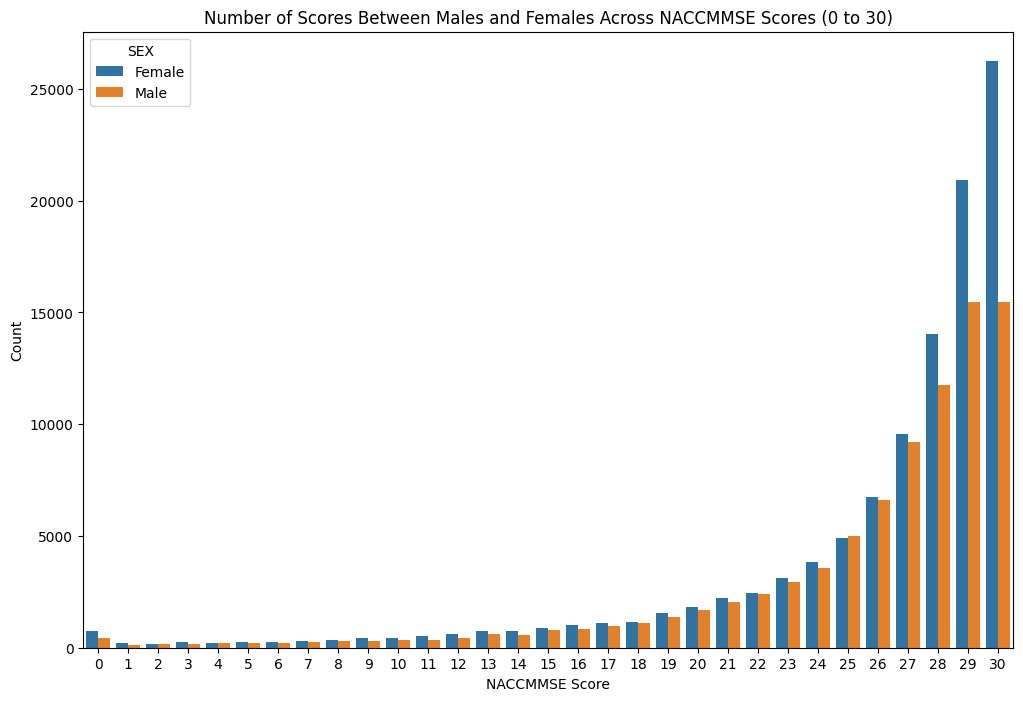

In [ ]:
# Histogram of the Total MMSE score 0 to 30 across gender
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for scores between 0 and 30
df_filtered = df[(df['NACCMMSE'] >= 0) & (df['NACCMMSE'] <= 30)]

# Map the numerical values in 'SEX' to labels
df_filtered['SEX'] = df_filtered['SEX'].map({1: 'Male', 2: 'Female'})

# Count the occurrences of each combination of 'SEX' and 'NACCMMSE'
score_counts = df_filtered.groupby(['SEX', 'NACCMMSE']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='NACCMMSE', y='Count', hue='SEX', data=score_counts)
plt.title('Number of Scores Between Males and Females Across NACCMMSE Scores (0 to 30)')
plt.xlabel('NACCMMSE Score')
plt.ylabel('Count')
plt.show()

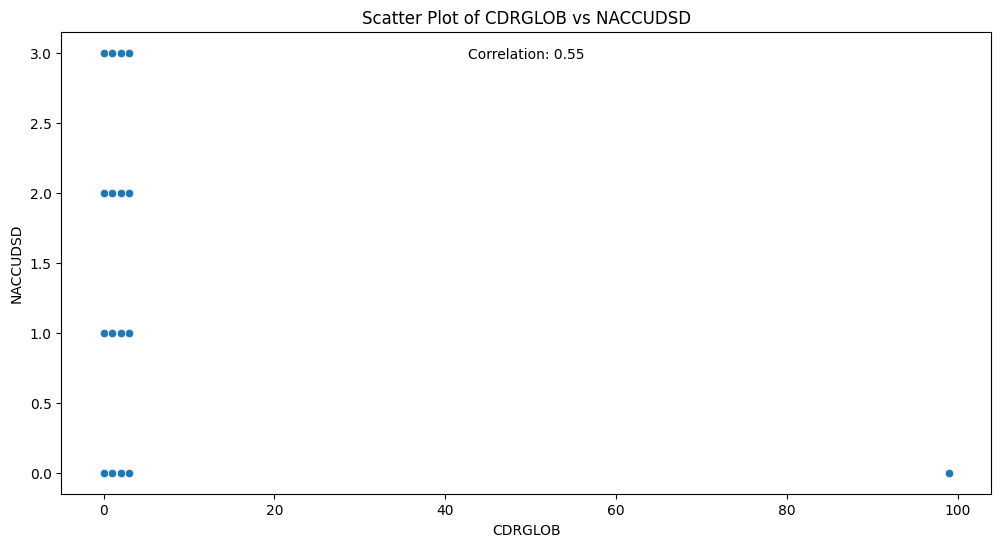

In [ ]:
# correlation scatter plot for CDRGLOB against target variable NACCUDSD
plot_column_vs_column(df, 'CDRGLOB', 'NACCUDSD', plot_type='scatter')

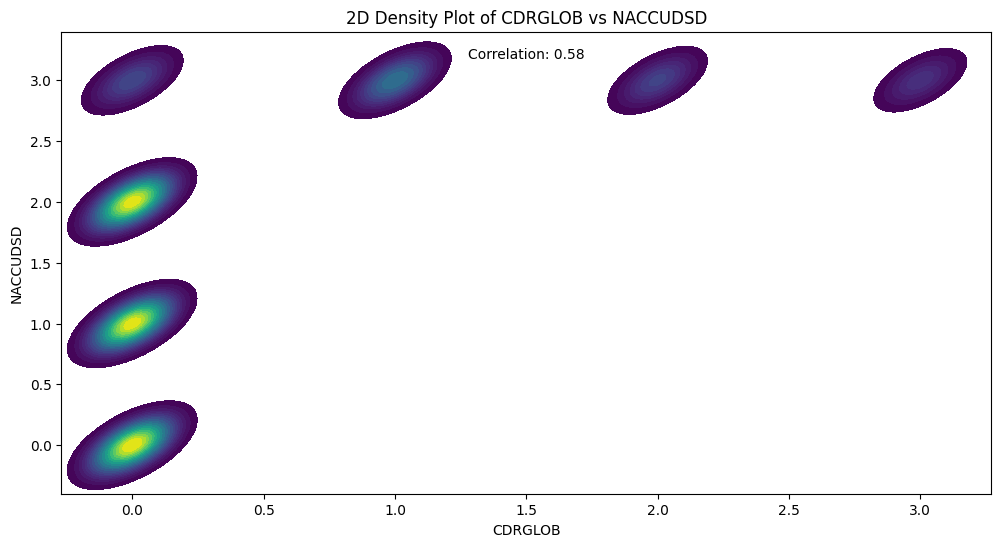

In [ ]:
#2D density plot for Global CDR 'CDRGLOB' score against target column 'NACCUDSD'
plot_column_vs_column(df, 'CDRGLOB', 'NACCUDSD', plot_type='density', values_range=(range(31)))

In [ ]:
# Check the distribution of the target variable
print("Class distribution:\n", df['NACCUDSD'].value_counts())

Class distribution:
 NACCUDSD
2    87792
0    87792
3    87792
1    87792
Name: count, dtype: int64


# **Defining train and evaluate LSTM Model**

---





#**GitHub Upload commands**